### Relevant Libraries

In [1]:
push!(LOAD_PATH, "../src/")
using GP, PyPlot, Logging
Logging.configure(level=DEBUG, filename="oracle.ml.log")

Logger(root,DEBUG,IOStream(<file oracle.ml.log>),root)

In [2]:
# start the parallel processes
if length(workers()) > 1
    rmprocs(workers())
end
addprocs(11)
@everywhere push!(LOAD_PATH, "../src/")
@everywhere using GP

### Simulation profiles

In [6]:
# simulation profiles
# num neurons
Ms = round(Int64, logspace(log10(20), log10(500), 10))
# three different combinations of smoothness and noise std (signal std = 1)
Δs, σns = Float64[2, 2, 0.5], Float64[1, sqrt(0.1), sqrt(0.1)]
# resolution to sample the tuning curves at
res = 1024
# decoding at every "step" samples of the true tuning curves are tested
step = 8
ntest = round(Int64, res / step)
# stimuli corresponding to the sampled true tuning curves
θs = linspace(0, 2π, res+1)[1:res]
# test stimuli
θs_test = θs[1:step:res]

linspace(0.0,6.234097921967246,128)

### Run oracle decoding

In [30]:
# draw all the data
errs = zeros(length(Ms), length(Δs), ntest)
# stepping through smoothness and snr combinations
for (ix, (Δ, σn)) in enumerate(zip(Δs, σns))
    # looping over population size
    for (ixM, M) in enumerate(Ms)
        debug("ix: $ix, ixM: $ixM") # write to log file to track progress
        ker = GP.Kernel(Δ)
        # generate the population of tuning curves
        θs, xs = tc(res, M, ker)
        # responses values at test stimuli
        rs_test = xs[1:step:end, :] + randn(ntest, M) * σn
        # decoding by finding the cloest point on the manifold from the test responses
        helper(x, Y) = findmin(vec(sum((x .- Y).^2, 2)))[2]
        min_ix = pmap(helper, [rs_test[t, :] for t in 1:ntest], [xs for t in 1:ntest]) # parallel map
        min_ix = convert(Array{Int64, 1}, min_ix)
        θs_test_hat = θs[min_ix]
        
        # compute the squared error by unrolling the angular variable first
        errs[ixM, ix, :] = imag(log(exp((θs_test_hat - θs_test) * 1im)))
    end
end

### Plot results

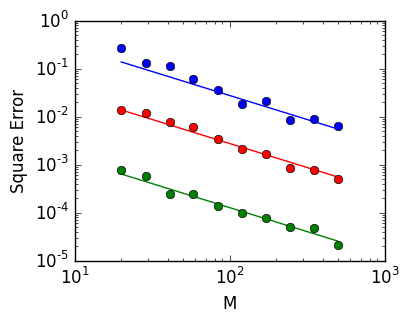

PyObject <matplotlib.text.Text object at 0x7f2fa169bd68>

In [36]:
figure(figsize=(4, 3))
colors = ["b", "r", "g"]
for (ix, (Δ, σn)) in enumerate(zip(Δs, σns))
    plot(Ms, 1 ./ (Ms  / (cosh(Δ) - 1) * 1 / σn^2), colors[ix] * "-")
    plot(Ms, vec(mean(errs[:, ix, :].^2, 3)), colors[ix] * "o")
end
xscale("log"); yscale("log")
xlabel("M"); ylabel("Square Error")